In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import optuna

import cv2

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F

In [89]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

**считываем данные**

в тренировочной выборке имеем 42000 картинок 

In [52]:
df_train, df_test = pd.read_csv('train.csv'), pd.read_csv('test.csv')
print(df_train.shape, df_test.shape)

(42000, 785) (28000, 784)


In [53]:
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
df_train.iloc[0, 1:].value_counts()

0
0      687
253     24
254      6
94       3
93       3
80       2
89       2
20       2
13       2
188      2
209      2
7        2
248      2
250      2
191      2
240      2
22       1
196      1
198      1
203      1
76       1
168      1
25       1
245      1
103      1
195      1
15       1
220      1
251      1
131      1
214      1
218      1
206      1
23       1
27       1
235      1
255      1
123      1
167      1
10       1
247      1
208      1
29       1
207      1
77       1
81       1
54       1
88       1
238      1
170      1
17       1
210      1
159      1
16       1
95       1
Name: count, dtype: int64

**датасет достаточно сбалансированный**

In [55]:
df_train['label'].value_counts()

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

**посмотрим на содержимое датасета**

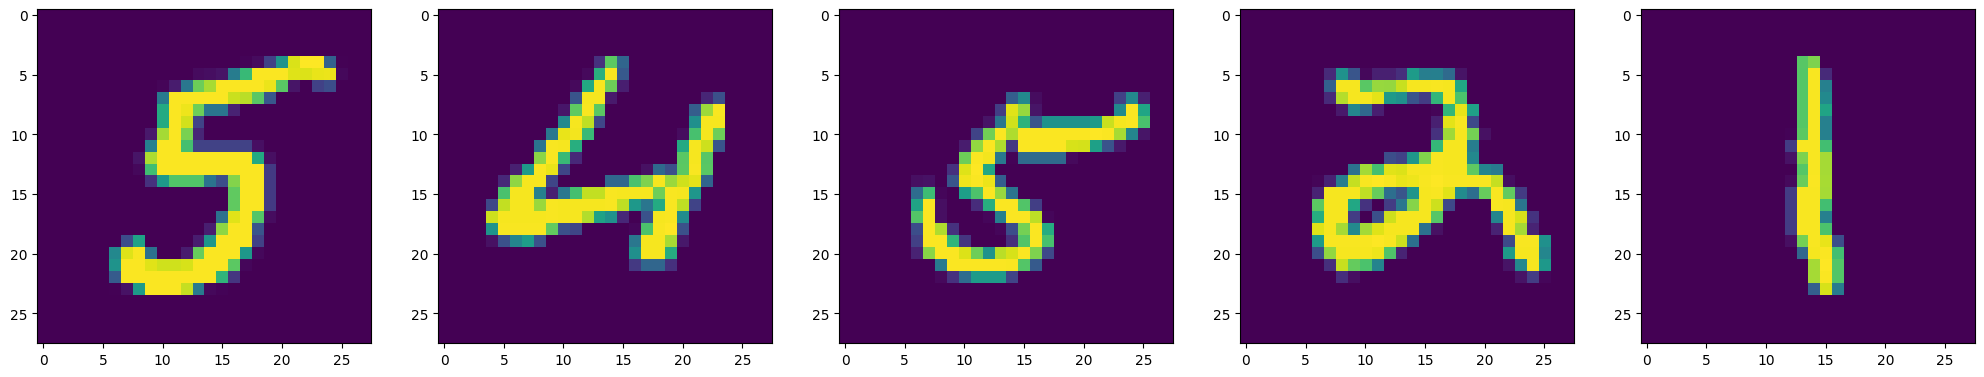

In [56]:
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

for ax in axes:
    row = np.random.randint(len(df_train))
    ax.imshow(df_train.iloc[row, 1:].values.reshape(-1, 28))
plt.show()

**подготовка данных**

In [81]:
def create_dataloaders(df, batch_size=256):
    X, Y = df.drop('label', axis=1).values, df['label'].values
    X = X.astype(float) / 255
    X = X.reshape(-1, 1, 28, 28)

    X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

    # Create tensors and dataloaders
    X_train =  torch.from_numpy(X_train).float()
    y_train =  torch.from_numpy(y_train)
    train_tensor = TensorDataset(X_train, y_train)

    X_val =  torch.from_numpy(X_val).float()
    y_val =  torch.from_numpy(y_val)
    val_tensor = TensorDataset(X_val, y_val)

    train_loader = DataLoader(train_tensor, batch_size=batch_size, num_workers=2, shuffle=True)
    val_loader = DataLoader(val_tensor, batch_size=batch_size, num_workers=2, shuffle=False)

    return train_loader, val_loader

In [82]:
train_loader, val_loader = create_dataloaders(df_train)

In [83]:
for batch in train_loader:
    print(batch[0].shape)
    print(batch[1].shape)
    break

torch.Size([256, 1, 28, 28])
torch.Size([256])


**определяем модель**

In [84]:
from typing import List

class neural_network(nn.Module):
    def __init__(self, in_features: int = 784, n_classes: int = 10, 
                 hidden_size: int = 16, hidden_layers=2, activation=nn.ReLU):
        super().__init__()
        self.flatten = nn.Flatten()
        modules = [nn.Linear(in_features, hidden_size), activation()]

        for i in range(hidden_layers):
            modules.append(nn.Linear(hidden_size, hidden_size))
            modules.append(activation())
        
        modules.append(nn.Linear(hidden_size, n_classes))
        
        self.sequential = nn.Sequential(*modules)
    
    def forward(self, x):
        x = self.flatten(x)
        return self.sequential(x)

**обучение полносвязной нейронной сети (MLP)**

In [133]:
model = neural_network()
model.to(device)

neural_network(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (sequential): Sequential(
    (0): Linear(in_features=784, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=10, bias=True)
  )
)

In [134]:
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

**подбор гиперпараметров**

подберём оптимальное число слоёв и число нейронов на каждом слое

для этого воспользуемся фреймворком optuna

In [172]:
import os
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

def model_fit(model, optimizer, criterion, train_loader, val_loader, n_epochs=100, models_path='models', 
              verbose=True, save_best=True):
  train_accuracies, val_accuracies  = [], []
  train_losses, val_losses = [], []
  min_val_losses = 1000

  for i in tqdm(range(n_epochs), desc='epoch'):
    train_losses_per_epoch, train_accs = [], []
    model.train()

    #эпоха обучения
    for x_batch, y_batch in train_loader: #, total=len(train_loader), desc='train loader'):
      optimizer.zero_grad()
      output = model(x_batch.to(device))
      loss = criterion(output, y_batch.to(device))
      loss.backward()
      optimizer.step()

      train_losses_per_epoch.append(loss.item())
      train_accs.append(accuracy_score(y_batch, output.argmax(axis=1).cpu()))

    train_losses.append(np.mean(train_losses_per_epoch))
    train_accuracies.append(np.mean(train_accs))

    #цикл валидации
    val_losses_per_epoch, val_accs = [], []
    model.eval()
    with torch.no_grad():
      for x_batch, y_batch in val_loader: #, total=(len(val_loader)), desc='val loader'):
        output = model(x_batch.to(device))
        loss = criterion(output, y_batch.to(device))

        val_losses_per_epoch.append(loss.item())
        val_accs.append(accuracy_score(y_batch, output.argmax(axis=1).cpu()))

    val_losses.append(np.mean(val_losses_per_epoch))
    val_accuracies.append(np.mean(val_accs))

    #сохранение лучшей модели:
    if save_best:
      if val_losses[-1] < min_val_losses:
        min_val_losses = val_losses[-1]
        if len(os.listdir(models_path)) > 0:
          for name in os.listdir(f'{models_path}'):
            os.remove(f'{models_path}/{name}')
          
        torch.save(model.state_dict(), f'{models_path}/mlp_val_loss_{round(val_losses[-1], 3)}_epoch_{i+1}.pkl')
      
    if verbose:
      print('epoch: {} \ntrain losses: {:.5f}, val losses: {:.5f}, train accuracy: {:.5f}, val accuracy: {:.5f}\n'.format(
        i+1, train_losses[-1], val_losses[-1], train_accuracies[-1], val_accuracies[-1])
      )

  return train_losses, val_losses, train_accuracies, val_accuracies 

In [136]:
train_losses, val_losses, train_accs, val_accs = model_fit(
    model=model, optimizer=optimizer, criterion=loss_fn, 
    train_loader=train_loader, val_loader=val_loader
)

epoch:   0%|          | 0/100 [00:00<?, ?it/s]

epoch: 1 
train losses: 1.70736, val losses: 0.83550, train accuracy: 0.43694, val accuracy: 0.75497

epoch: 2 
train losses: 0.65262, val losses: 0.55502, train accuracy: 0.79936, val accuracy: 0.83768

epoch: 3 
train losses: 0.51059, val losses: 0.47501, train accuracy: 0.84556, val accuracy: 0.86245

epoch: 4 
train losses: 0.42519, val losses: 0.39816, train accuracy: 0.87491, val accuracy: 0.88718

epoch: 5 
train losses: 0.35888, val losses: 0.36005, train accuracy: 0.89592, val accuracy: 0.90005

epoch: 6 
train losses: 0.32372, val losses: 0.33110, train accuracy: 0.90702, val accuracy: 0.90695

epoch: 7 
train losses: 0.29867, val losses: 0.31156, train accuracy: 0.91315, val accuracy: 0.91111

epoch: 8 
train losses: 0.27786, val losses: 0.29622, train accuracy: 0.91939, val accuracy: 0.91485

epoch: 9 
train losses: 0.26306, val losses: 0.28575, train accuracy: 0.92315, val accuracy: 0.91756

epoch: 10 
train losses: 0.24989, val losses: 0.27062, train accuracy: 0.92756, va

**видно, что начиная примерно с 40 эпохи началось переобучение**

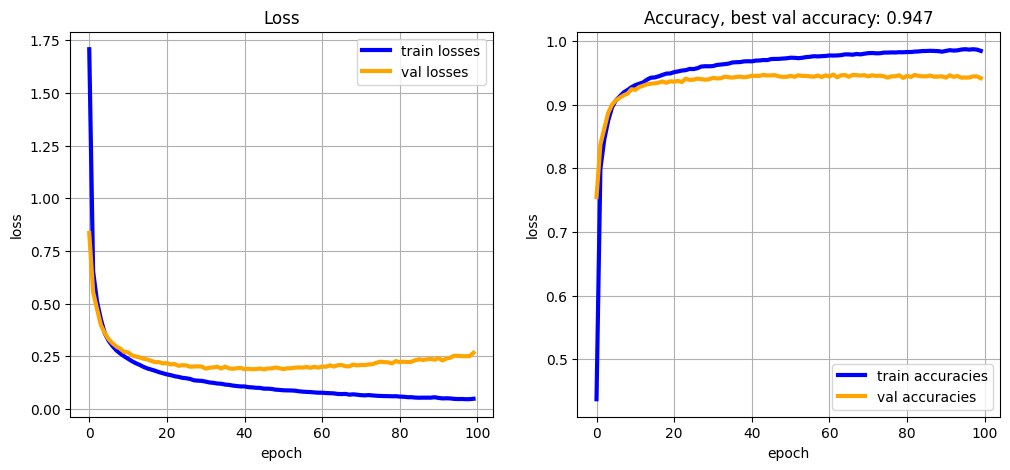

In [141]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(train_losses, color='blue', lw=3, label='train losses')
plt.plot(val_losses, color='orange', lw=3, label='val losses')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy, best val accuracy: {:.3f}'.format(np.max(val_accs)))
plt.plot(train_accs, color='blue', lw=3, label='train accuracies')
plt.plot(val_accs, color='orange', lw=3, label='val accuracies')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid(True)
plt.legend()

plt.show()

**измерим итоговое качество на тесте**

возьмём модель, достигшую лучшего качество на валидации

In [143]:
best_model = neural_network()
name = os.listdir('models')[0]
best_model.load_state_dict(torch.load(f'models/{name}'))

<All keys matched successfully>

In [155]:
test_tensor = (pd.read_csv('test.csv').values.astype(float) / 255).reshape(-1, 1, 28, 28)
test_tensor = torch.from_numpy(test_tensor).float()
test_tensor.shape

torch.Size([28000, 1, 28, 28])

In [153]:
idxes = np.random.randint(1, len(test_tensor), 25)
idxes

array([11442, 15288, 26185,  8203, 22973, 22161,  5981,  1860, 20059,
        3706, 10173, 26234, 22927, 21410,  5293, 25372, 18347, 15173,
        2980, 23860, 12046, 11829,  3843,  3314, 13935])

In [163]:
model.eval()
with torch.no_grad():
    preds = model(test_tensor[idxes, :].to(device)).cpu().numpy().argmax(axis=1)

**видно, что наша нейросеть неплохо справляется, но всё же допускает ошибки**

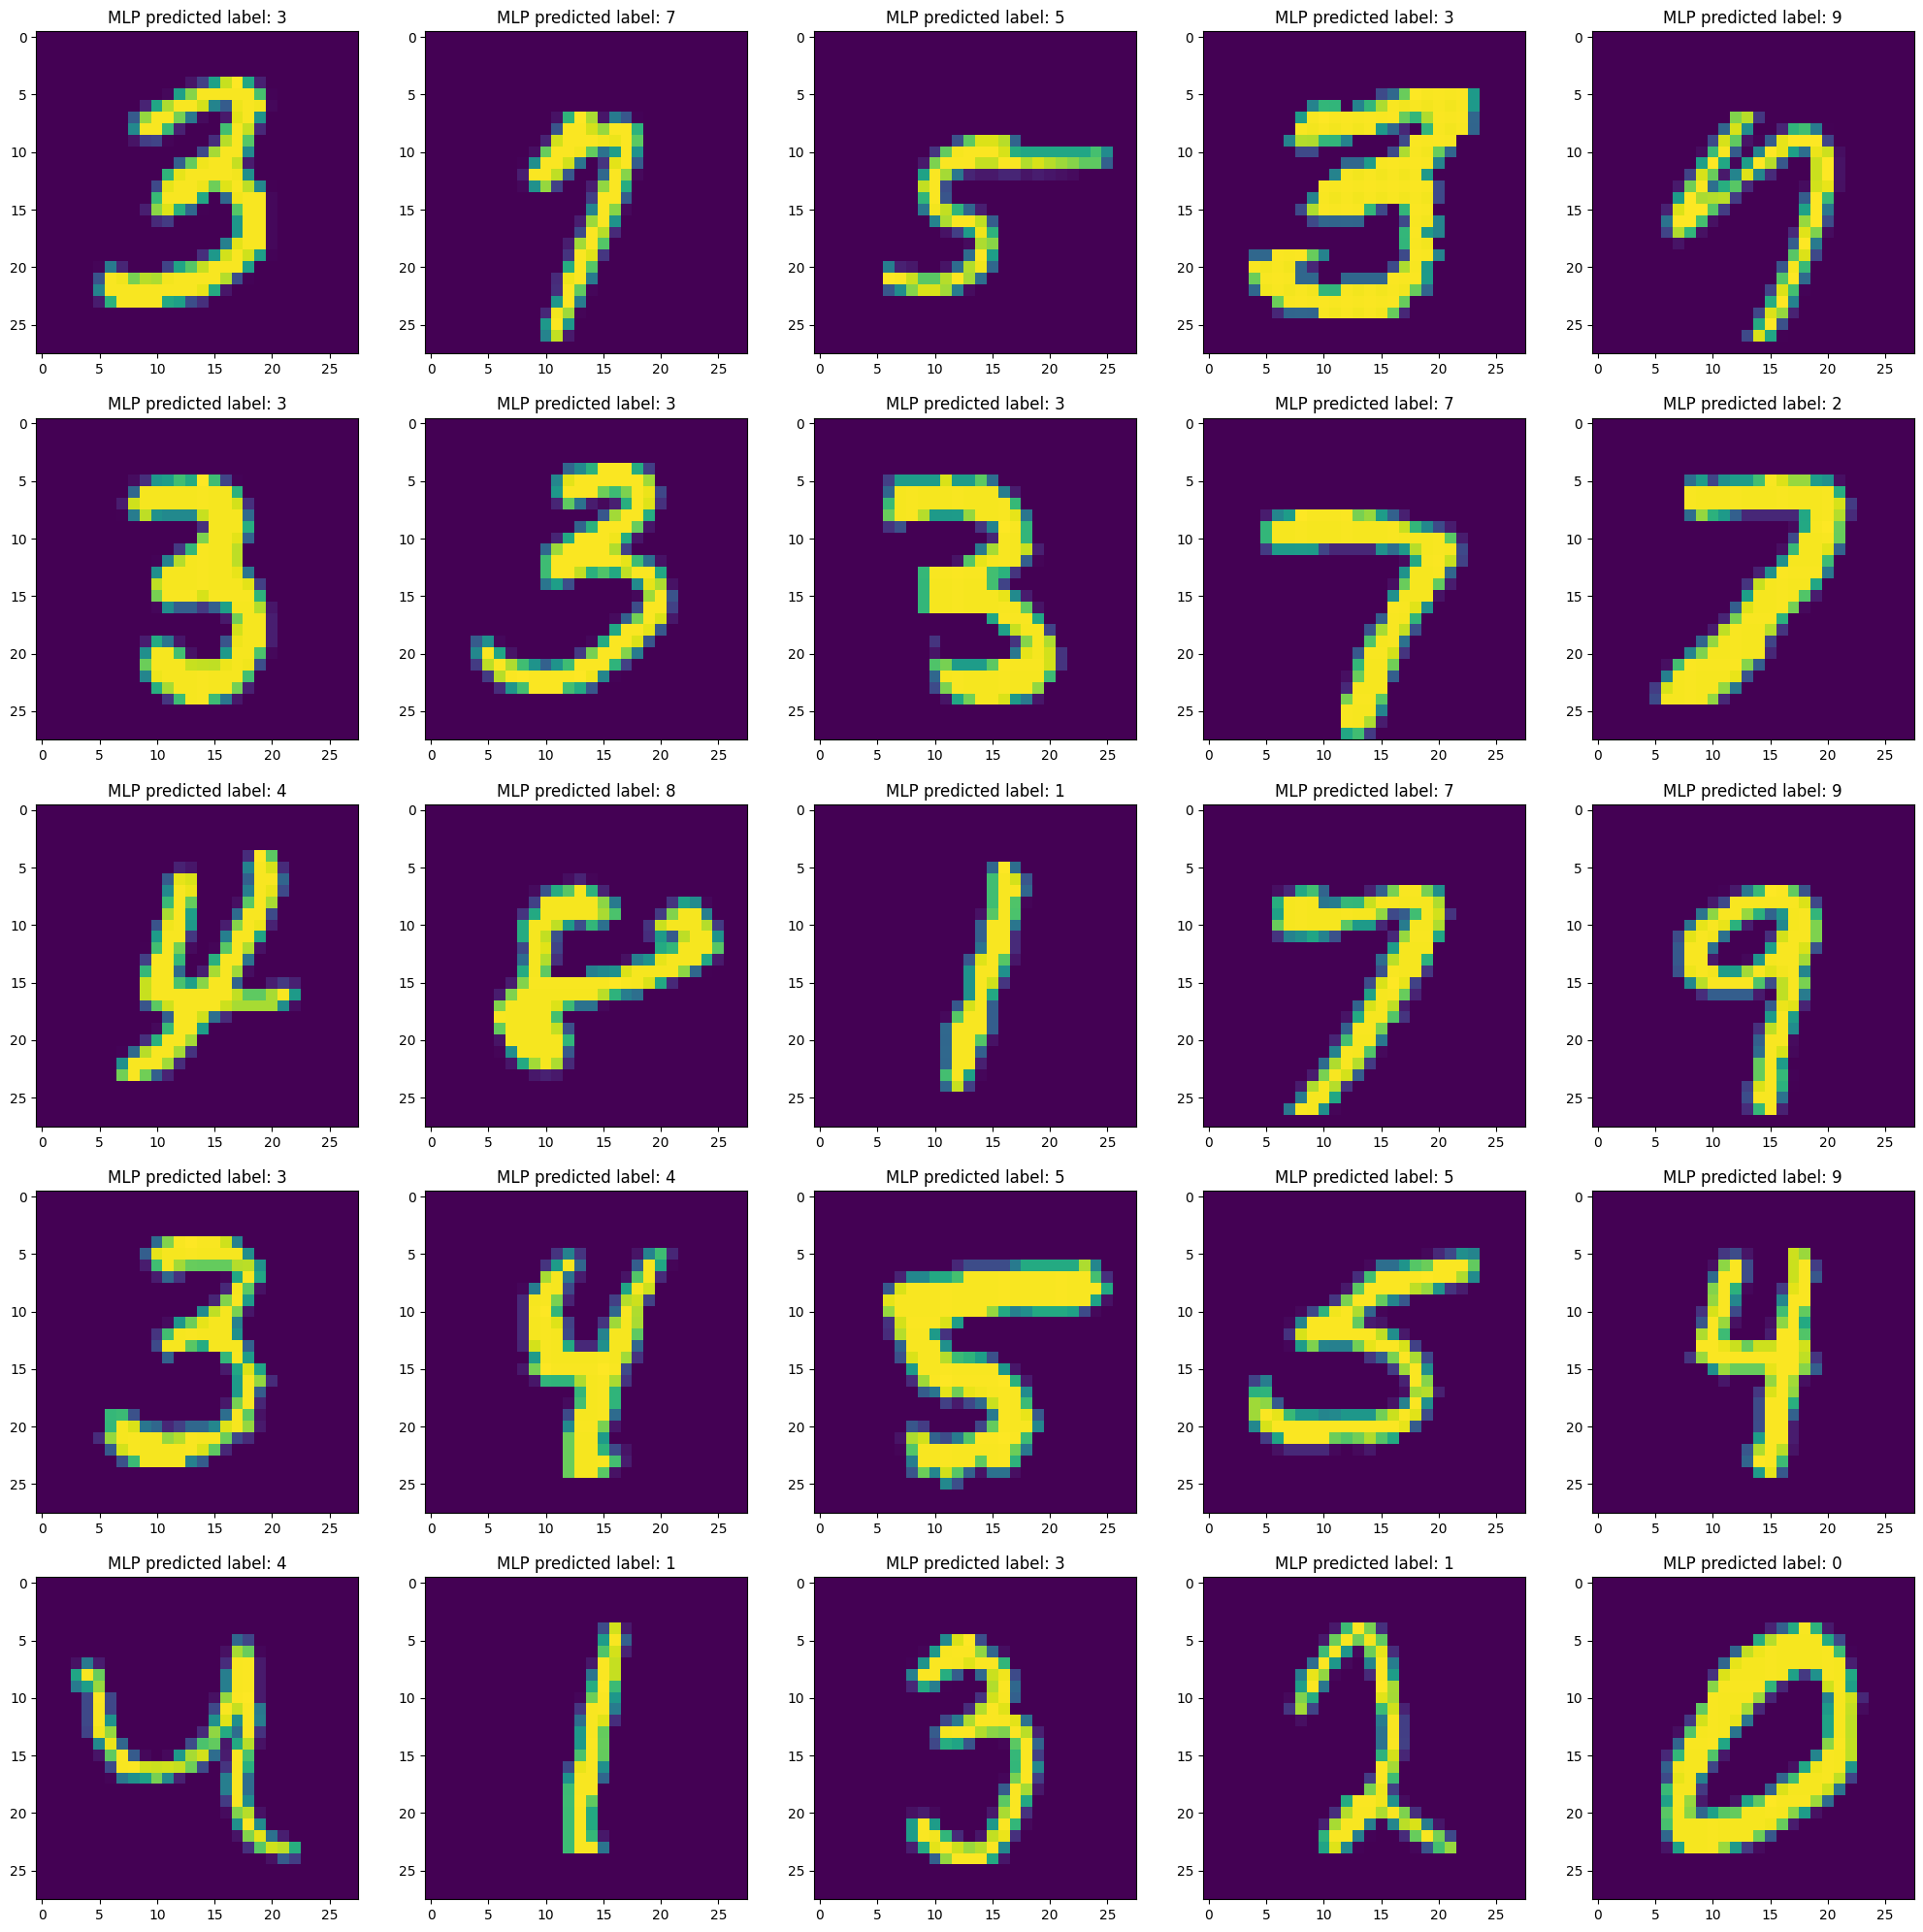

In [167]:
fig, axes = plt.subplots(5, 5, figsize=(25, 25))

for i in range(5):
    for j in range(5):
        axes[i, j].set_title(f'MLP predicted label: {preds[i*5 + j]}')
        axes[i, j].imshow(test_tensor[idxes[i*5 + j]].numpy().squeeze())
plt.show()

# подбор гиперпараметров

**воспользуемся фреймворком optuna для подбора лучших гиперпараметров**

1) подберём оптимальное число слоёв
2) подберём оптимальное число нейронов в скрытых слоях сети

In [180]:
def objective(trial, train_dataloader, val_dataloader):
    params= {
        'hidden_layers': trial.suggest_int('hidden_layers', 1, 5),
        'hidden_size': trial.suggest_int('hidden_size', 16, 128)
    }

    model = neural_network(**params)
    model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    _, val_losses, _, val_accs = model_fit(
        model=model, optimizer=optimizer, criterion=loss_fn, n_epochs=50,
        train_loader=train_loader, val_loader=val_loader,
        verbose=False, save_best=False
    )

    best_accuracy = np.max(val_accs)
    best_epoch = np.argmax(val_accs)

    print('best accuracy: {:.3f}, best epoch: {:.3f}'.format(best_accuracy, best_epoch))

    return best_accuracy

In [181]:
study = optuna.create_study(direction='maximize', study_name='MLP')
func = lambda trial: objective(trial, train_loader, val_loader)

[I 2023-12-24 02:23:06,729] A new study created in memory with name: MLP


In [182]:
study.optimize(func, n_trials=30, show_progress_bar=True)

  0%|          | 0/30 [00:00<?, ?it/s]

epoch:   0%|          | 0/50 [00:00<?, ?it/s]

best accuracy: 0.962, best epoch: 34.000
[I 2023-12-24 02:27:53,458] Trial 0 finished with value: 0.9620210518648018 and parameters: {'hidden_layers': 2, 'hidden_size': 37}. Best is trial 0 with value: 0.9620210518648018.


epoch:   0%|          | 0/50 [00:00<?, ?it/s]

best accuracy: 0.961, best epoch: 42.000
[I 2023-12-24 02:32:50,776] Trial 1 finished with value: 0.9610194493006993 and parameters: {'hidden_layers': 5, 'hidden_size': 50}. Best is trial 0 with value: 0.9620210518648018.


epoch:   0%|          | 0/50 [00:00<?, ?it/s]

best accuracy: 0.959, best epoch: 46.000
[I 2023-12-24 02:37:45,598] Trial 2 finished with value: 0.9585609702797203 and parameters: {'hidden_layers': 4, 'hidden_size': 34}. Best is trial 0 with value: 0.9620210518648018.


epoch:   0%|          | 0/50 [00:00<?, ?it/s]

best accuracy: 0.971, best epoch: 49.000
[I 2023-12-24 02:42:38,419] Trial 3 finished with value: 0.9711629516317016 and parameters: {'hidden_layers': 4, 'hidden_size': 77}. Best is trial 3 with value: 0.9711629516317016.


epoch:   0%|          | 0/50 [00:00<?, ?it/s]

best accuracy: 0.972, best epoch: 37.000
[I 2023-12-24 02:47:29,860] Trial 4 finished with value: 0.9721918706293707 and parameters: {'hidden_layers': 3, 'hidden_size': 93}. Best is trial 4 with value: 0.9721918706293707.


epoch:   0%|          | 0/50 [00:00<?, ?it/s]

best accuracy: 0.964, best epoch: 34.000
[I 2023-12-24 02:52:17,717] Trial 5 finished with value: 0.9644157925407926 and parameters: {'hidden_layers': 2, 'hidden_size': 49}. Best is trial 4 with value: 0.9721918706293707.


epoch:   0%|          | 0/50 [00:00<?, ?it/s]

best accuracy: 0.974, best epoch: 36.000
[I 2023-12-24 02:57:10,127] Trial 6 finished with value: 0.9735850087412588 and parameters: {'hidden_layers': 3, 'hidden_size': 109}. Best is trial 6 with value: 0.9735850087412588.


epoch:   0%|          | 0/50 [00:00<?, ?it/s]

best accuracy: 0.958, best epoch: 48.000
[I 2023-12-24 03:02:02,657] Trial 7 finished with value: 0.9579144813519813 and parameters: {'hidden_layers': 4, 'hidden_size': 43}. Best is trial 6 with value: 0.9735850087412588.


epoch:   0%|          | 0/50 [00:00<?, ?it/s]

best accuracy: 0.949, best epoch: 44.000
[I 2023-12-24 03:06:48,688] Trial 8 finished with value: 0.9492733828671328 and parameters: {'hidden_layers': 2, 'hidden_size': 16}. Best is trial 6 with value: 0.9735850087412588.


epoch:   0%|          | 0/50 [00:00<?, ?it/s]

best accuracy: 0.973, best epoch: 48.000
[I 2023-12-24 03:11:41,572] Trial 9 finished with value: 0.9728747814685316 and parameters: {'hidden_layers': 3, 'hidden_size': 110}. Best is trial 6 with value: 0.9735850087412588.


epoch:   0%|          | 0/50 [00:00<?, ?it/s]

best accuracy: 0.974, best epoch: 47.000
[I 2023-12-24 03:16:30,906] Trial 10 finished with value: 0.9743589743589743 and parameters: {'hidden_layers': 1, 'hidden_size': 124}. Best is trial 10 with value: 0.9743589743589743.


epoch:   0%|          | 0/50 [00:00<?, ?it/s]

best accuracy: 0.974, best epoch: 38.000
[I 2023-12-24 03:21:47,497] Trial 11 finished with value: 0.9741495483682984 and parameters: {'hidden_layers': 1, 'hidden_size': 127}. Best is trial 10 with value: 0.9743589743589743.


epoch:   0%|          | 0/50 [00:00<?, ?it/s]

best accuracy: 0.974, best epoch: 38.000
[I 2023-12-24 03:26:33,145] Trial 12 finished with value: 0.9739674388111889 and parameters: {'hidden_layers': 1, 'hidden_size': 125}. Best is trial 10 with value: 0.9743589743589743.


epoch:   0%|          | 0/50 [00:00<?, ?it/s]

[W 2023-12-24 03:29:11,026] Trial 13 failed with parameters: {'hidden_layers': 1, 'hidden_size': 127} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\alexa\miniconda3\envs\gputest\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\alexa\AppData\Local\Temp\ipykernel_12964\2154285242.py", line 2, in <lambda>
    func = lambda trial: objective(trial, train_loader, val_loader)
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\alexa\AppData\Local\Temp\ipykernel_12964\1583060083.py", line 12, in objective
    _, val_losses, _, val_accs = model_fit(
                                 ^^^^^^^^^^
  File "C:\Users\alexa\AppData\Local\Temp\ipykernel_12964\2072541050.py", line 24, in model_fit
    train_accs.append(accuracy_score(y_batch, output.argmax(axis=1).cpu()))
                      ^^^^^^^^^^^^^^^^^

KeyboardInterrupt: 

**в процессе подбора гиперпараметров стало ясно, что сети важно большое число нейронов на первых слоях**

**также нейронной сети не нужно много слоёв, иначе она быстро начинает переобучаться**

In [186]:
class neural_network_custom(nn.Module):
    def __init__(self, in_features: int = 784, n_classes: int = 10, 
                 activation=nn.ReLU):
        super().__init__()
        self.flatten = nn.Flatten()
        self.sequential = nn.Sequential(
            nn.Linear(in_features, 512),
            activation(),
            nn.Linear(512, 256),
            activation(),
            nn.Linear(256, 32),
            activation(),
            nn.Linear(32, n_classes)
        )
    
    def forward(self, x):
        x = self.flatten(x)
        return self.sequential(x)

In [189]:
def visualize_test(model, test_tensor, test_idxes):
    model.eval()
    with torch.no_grad():
        preds = model(test_tensor[test_idxes, :].to(device)).cpu().numpy().argmax(axis=1)
    
    fig, axes = plt.subplots(5, 5, figsize=(25, 25))

    for i in range(5):
        for j in range(5):
            axes[i, j].set_title(f'MLP predicted label: {preds[i*5 + j]}')
            axes[i, j].imshow(test_tensor[test_idxes[i*5 + j]].numpy().squeeze())
    plt.show()

In [187]:
model_custom = neural_network_custom()
model_custom.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_custom.parameters())

_, val_losses, _, val_accs = model_fit(
    model=model_custom, optimizer=optimizer, criterion=loss_fn, n_epochs=50,
    train_loader=train_loader, val_loader=val_loader,
    verbose=False, save_best=False
)

best_accuracy = np.max(val_accs)
best_epoch = np.argmax(val_accs)
print('best accuracy: {:.3f}, best epoch: {:.3f}'.format(best_accuracy, best_epoch))

epoch:   0%|          | 0/50 [00:00<?, ?it/s]

best accuracy: 0.980, best epoch: 40.000


**по итогу видно, что у модели с точностью 98% на тесте стало на две ошибки меньше** 

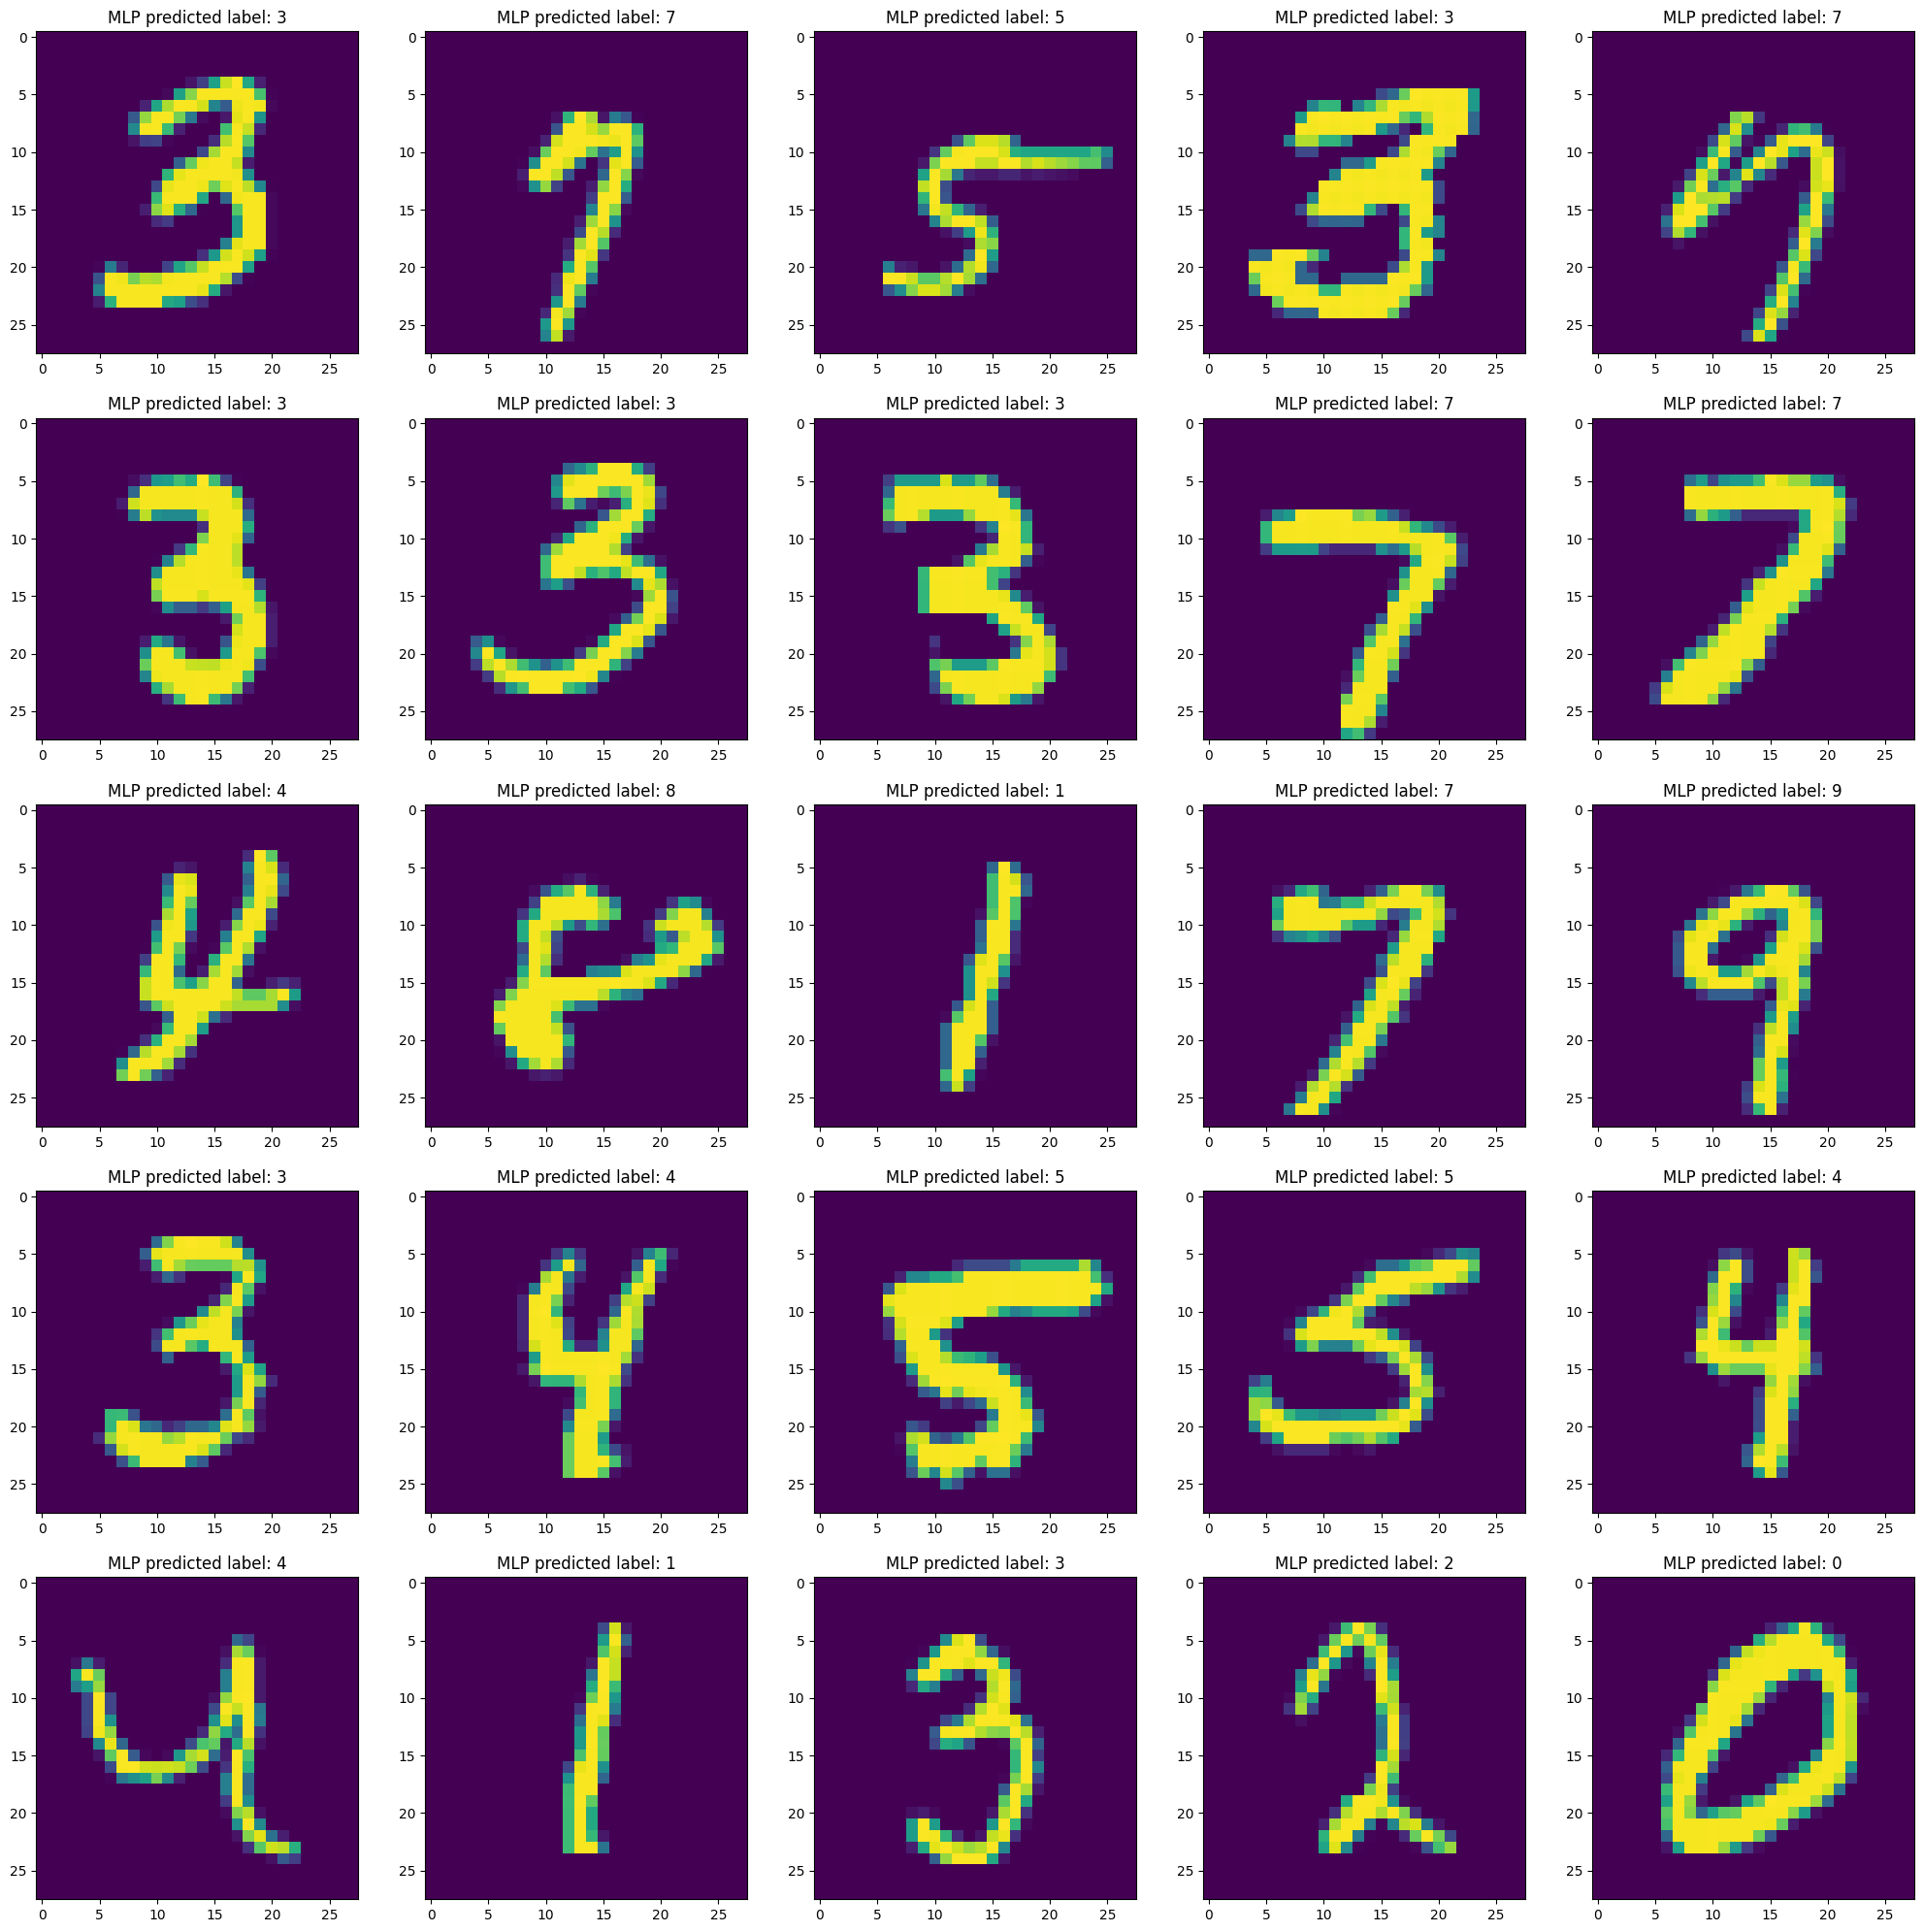

In [191]:
visualize_test(model=model_custom, test_tensor=test_tensor, test_idxes=idxes)